In [44]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np
import pickle
# For plotting
%matplotlib inline
import matplotlib.pyplot as plt

# For the implementation of the Keras models
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu
# Set seed for reproducable results
sn.config.seed = 42
import numpy as np

In [45]:
class ResidualBlock(Layer):

    def __init__(self):
        super().__init__()

        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=128,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=128,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z) # [batch size, num time samples, num subcarriers, num_channels]
        # Skip connection
        z = z + inputs

        return z

class NeuralReceiver(Layer):

    def __init__(self):
        super().__init__()

        # Input convolution
        self._input_conv = Conv2D(filters=128,
                                  kernel_size=[3,3],
                                  padding='same',
                                  activation=None)
        # Residual blocks
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        # Output conv
        self._output_conv = Conv2D(filters=NUM_BITS_PER_SYMBOL,
                                   kernel_size=[3,3],
                                   padding='same',
                                   activation=None)

    def call(self, inputs):
        y, no = inputs

        # Assuming a single receiver, remove the num_rx dimension
        y = tf.squeeze(y, axis=1)

        # Feeding the noise power in log10 scale helps with the performance
        no = sn.utils.log10(no)

        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = sn.utils.insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        # z : [batch size, num ofdm symbols, num subcarriers, 2*num rx antenna + 1]
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)
        # Input conv
        z = self._input_conv(z)
        # Residual blocks
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        # Output conv
        z = self._output_conv(z)

        # Reshape the input to fit what the resource grid demapper is expected
        z = sn.utils.insert_dims(z, 2, 1)

        return z

In [46]:
class OFDMSystem(Model): # Inherits from Keras Model

    def __init__(self, perfect_csi):
        super().__init__() # Must call the Keras model initializer

        self.perfect_csi = perfect_csi

        n = int(RESOURCE_GRID.num_data_symbols*NUM_BITS_PER_SYMBOL) # Number of coded bits
        k = int(n*CODERATE) # Number of information bits
        self.k = k

        # The binary source will create batches of information bits
        self.binary_source = sn.utils.BinarySource()

        # The encoder maps information bits to coded bits
        self.encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = sn.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

        # The resource grid mapper maps symbols onto an OFDM resource grid
        self.rg_mapper = sn.ofdm.ResourceGridMapper(RESOURCE_GRID)

        # Frequency domain channel
        self.channel = sn.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=True)

        # The LS channel estimator will provide channel estimates and error variances
        self.ls_est = sn.ofdm.LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")

        # The LMMSE equalizer will provide soft symbols together with noise variance estimates
        self.lmmse_equ = sn.ofdm.LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGEMENT)

        # The demapper produces LLR for all coded bits
        self.demapper = sn.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL)

        # The decoder provides hard-decisions on the information bits
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    @tf.function # Graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=RESOURCE_GRID)

        # Transmitter
        bits = self.binary_source([batch_size, NUM_UT, RESOURCE_GRID.num_streams_per_tx, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        x_rg = self.rg_mapper(x)

        # Channel
        y, h_freq = self.channel([x_rg, no])

        # Receiver
        if self.perfect_csi:
            h_hat, err_var = h_freq, 0.
        else:
            h_hat, err_var = self.ls_est ([y, no])
        x_hat, no_eff = self.lmmse_equ([y, h_hat, err_var, no])
        llr = self.demapper([x_hat, no_eff])
        bits_hat = self.decoder(llr)

        return bits, bits_hat

In [47]:
NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 2
NUM_STREAMS_PER_TX = NUM_UT_ANT
RX_TX_ASSOCIATION = np.array([[1]])

STREAM_MANAGEMENT = sn.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)

NUM_BITS_PER_SYMBOL = 4 
CODERATE = 0.5

RESOURCE_GRID = sn.ofdm.ResourceGrid( num_ofdm_symbols=14,
                                      fft_size=76,
                                      subcarrier_spacing=30e3,
                                      num_tx=NUM_UT,
                                      num_streams_per_tx=NUM_STREAMS_PER_TX,
                                      cyclic_prefix_length=6,
                                      pilot_pattern="kronecker",
                                      pilot_ofdm_symbol_indices=[2,11])

DELAY_SPREAD = 100e-9 
DIRECTION = "uplink"  
CDL_MODEL = "C"       # Suitable values are ["A", "B", "C", "D", "E"]
SPEED = 10.0          # UT speed [m/s]. BSs are always assumed to be fixed.

CARRIER_FREQUENCY = 2.6e9 

UT_ARRAY = sn.channel.tr38901.Antenna(  polarization="single",
                                        polarization_type="V",
                                        antenna_pattern="38.901",
                                        carrier_frequency=CARRIER_FREQUENCY)

BS_ARRAY = sn.channel.tr38901.AntennaArray( num_rows=1,
                                            num_cols=int(NUM_BS_ANT/2),
                                            polarization="dual",
                                            polarization_type="cross",
                                            antenna_pattern="38.901", # Try 'omni'
                                            carrier_frequency=CARRIER_FREQUENCY)


CDL = sn.channel.tr38901.CDL(CDL_MODEL,
                             DELAY_SPREAD,
                             CARRIER_FREQUENCY,
                             UT_ARRAY,
                             BS_ARRAY,
                             DIRECTION,
                             min_speed=SPEED)

BATCH_SIZE = 128

In [48]:
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

ber_plots = sn.utils.PlotBER("OFDM over 3GPP CDL")

model_ls = OFDMSystem(False)
ber_plots.simulate(model_ls,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="LS Estimation 16QAM",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);

model_pcsi = OFDMSystem(True)
ber_plots.simulate(model_pcsi,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Perfect CSI 16QAM",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);



EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 4.6754e-01 | 1.0000e+00 |      109158 |      233472 |          128 |         128 |         2.2 |reached target block errors
   -8.947 | 4.6120e-01 | 1.0000e+00 |      107677 |      233472 |          128 |         128 |         0.5 |reached target block errors
   -7.895 | 4.5210e-01 | 1.0000e+00 |      105552 |      233472 |          128 |         128 |         0.5 |reached target block errors
   -6.842 | 4.3945e-01 | 1.0000e+00 |      102599 |      233472 |          128 |         128 |         0.4 |reached target block errors
   -5.789 | 4.2728e-01 | 1.0000e+00 |       99757 |      233472 |          128 |         128 |         0.4 |reached target block errors
   -4.737 | 4.0911e-01 | 1.0000e+00 |       95516 |      233472 |

In [49]:
NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 2
NUM_STREAMS_PER_TX = NUM_UT_ANT
RX_TX_ASSOCIATION = np.array([[1]])

STREAM_MANAGEMENT = sn.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)

NUM_BITS_PER_SYMBOL = 2
CODERATE = 0.5

RESOURCE_GRID = sn.ofdm.ResourceGrid( num_ofdm_symbols=14,
                                      fft_size=76,
                                      subcarrier_spacing=30e3,
                                      num_tx=NUM_UT,
                                      num_streams_per_tx=NUM_STREAMS_PER_TX,
                                      cyclic_prefix_length=6,
                                      pilot_pattern="kronecker",
                                      pilot_ofdm_symbol_indices=[2,11])

DELAY_SPREAD = 100e-9 
DIRECTION = "uplink"  
CDL_MODEL = "C"       # Suitable values are ["A", "B", "C", "D", "E"]
SPEED = 10.0          # UT speed [m/s]. BSs are always assumed to be fixed.

CARRIER_FREQUENCY = 2.6e9 

UT_ARRAY = sn.channel.tr38901.Antenna(  polarization="single",
                                        polarization_type="V",
                                        antenna_pattern="38.901",
                                        carrier_frequency=CARRIER_FREQUENCY)

BS_ARRAY = sn.channel.tr38901.AntennaArray( num_rows=1,
                                            num_cols=int(NUM_BS_ANT/2),
                                            polarization="dual",
                                            polarization_type="cross",
                                            antenna_pattern="38.901", # Try 'omni'
                                            carrier_frequency=CARRIER_FREQUENCY)


CDL = sn.channel.tr38901.CDL(CDL_MODEL,
                             DELAY_SPREAD,
                             CARRIER_FREQUENCY,
                             UT_ARRAY,
                             BS_ARRAY,
                             DIRECTION,
                             min_speed=SPEED)

BATCH_SIZE = 128

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 4.6782e-01 | 1.0000e+00 |       54612 |      116736 |          128 |         128 |         2.5 |reached target block errors
   -8.947 | 4.6332e-01 | 1.0000e+00 |       54086 |      116736 |          128 |         128 |         0.4 |reached target block errors
   -7.895 | 4.4888e-01 | 1.0000e+00 |       52400 |      116736 |          128 |         128 |         0.3 |reached target block errors
   -6.842 | 4.3916e-01 | 1.0000e+00 |       51266 |      116736 |          128 |         128 |         0.3 |reached target block errors
   -5.789 | 4.2569e-01 | 1.0000e+00 |       49693 |      116736 |          128 |         128 |         0.4 |reached target block errors
   -4.737 | 4.0614e-01 | 1.0000e+00 |       47411 |      116736 |

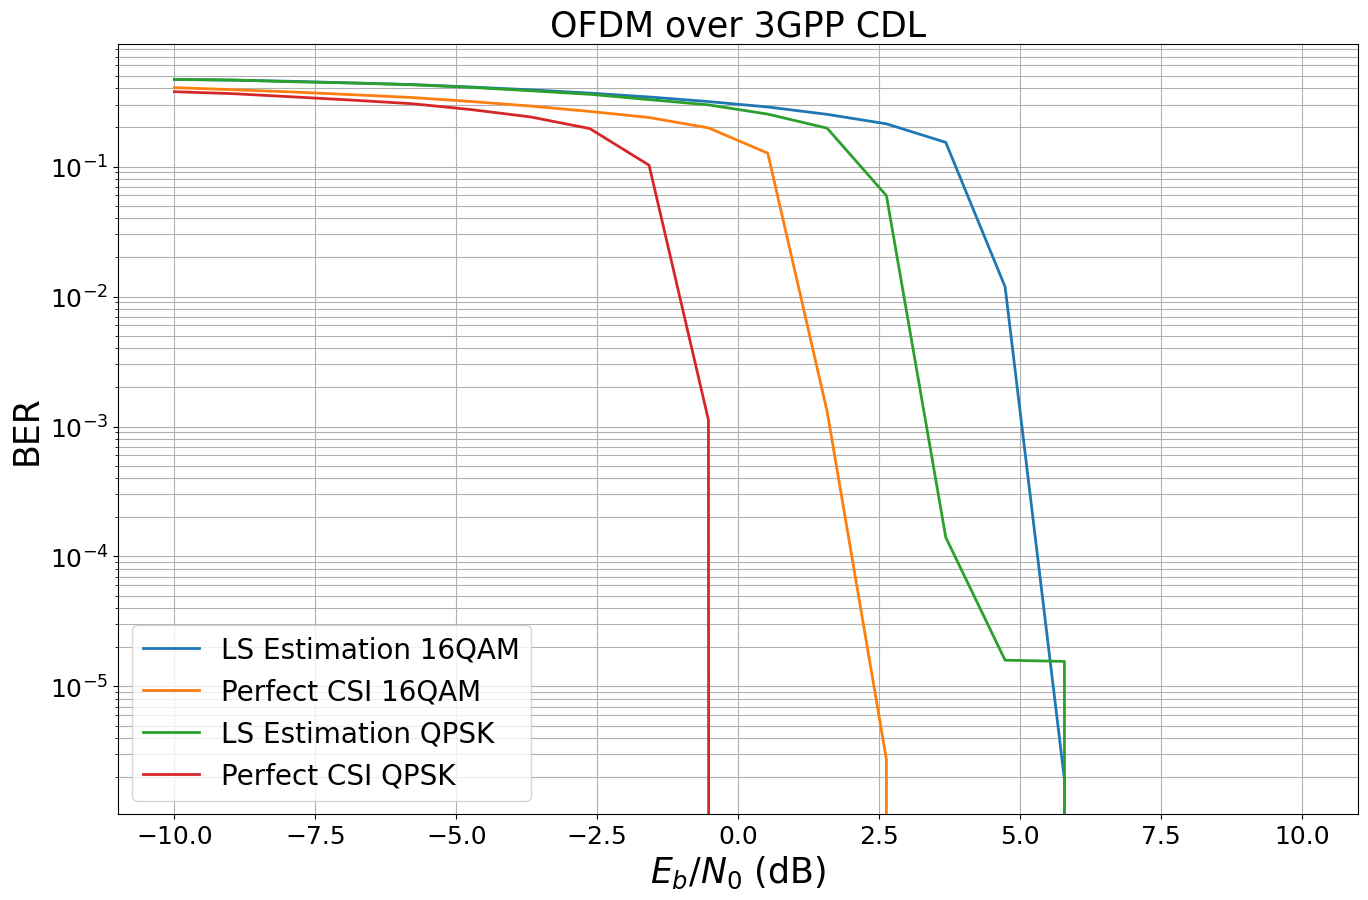

In [50]:
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations


model_ls = OFDMSystem(False)
ber_plots.simulate(model_ls,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="LS Estimation QPSK",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);

model_pcsi = OFDMSystem(True)
ber_plots.simulate(model_pcsi,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Perfect CSI QPSK",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);

ber_plots();

In [51]:
class OFDMSystemNeuralReceiver(Model): # Inherits from Keras Model

    def __init__(self, training):
        super().__init__() # Must call the Keras model initializer

        self.training = training

        n = int(RESOURCE_GRID.num_data_symbols*NUM_BITS_PER_SYMBOL) # Number of coded bits
        k = int(n*CODERATE) # Number of information bits
        self.k = k
        self.n = n

        # The binary source will create batches of information bits
        self.binary_source = sn.utils.BinarySource()

        # The encoder maps information bits to coded bits
        self.encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = sn.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

        # The resource grid mapper maps symbols onto an OFDM resource grid
        self.rg_mapper = sn.ofdm.ResourceGridMapper(RESOURCE_GRID)

        # Frequency domain channel
        self.channel = sn.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=False)

        # Neural receiver
        self.neural_receiver = NeuralReceiver()

        # Used to extract data-carrying resource elements
        self.rg_demapper = sn.ofdm.ResourceGridDemapper(RESOURCE_GRID, STREAM_MANAGEMENT)

        # The decoder provides hard-decisions on the information bits
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

        # Loss function
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True) # Loss function

    @tf.function # Graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=RESOURCE_GRID)

        # The neural receiver is expected no to have shape [batch_size].
        if len(no.shape) == 0:
            no = tf.fill([batch_size], no)

        # Transmitter
        # Outer coding is only performed if not training
        if self.training:
            codewords = self.binary_source([batch_size, NUM_UT, NUM_UT_ANT, self.n])
        else:
            bits = self.binary_source([batch_size, NUM_UT, NUM_UT_ANT, self.k])
            codewords = self.encoder(bits)
        x = self.mapper(codewords)
        x_rg = self.rg_mapper(x)

        # Channel
        y = self.channel([x_rg, no])

        # Receiver
        llr = self.neural_receiver([y, no])
        llr = self.rg_demapper(llr) # Extract data-carrying resource elements. The other LLrs are discarded
        llr = tf.reshape(llr, [batch_size, NUM_UT, NUM_UT_ANT, self.n]) # Reshape the LLRs to fit what the outer decoder is expected
        if self.training:
            loss = self.bce(codewords, llr)
            return loss
        else:
            bits_hat = self.decoder(llr)
            return bits, bits_hat

In [52]:
# Instantiating the end-to-end model for evaluation
model_neuralrx = OFDMSystemNeuralReceiver(training=False)

# Run one inference to build the layers and loading the weights
model_neuralrx(tf.constant(1, tf.int32), tf.constant(10.0, tf.float32))
with open('weights-ofdm-neuralrx', 'rb') as f:
    weights = pickle.load(f)
    model_neuralrx.set_weights(weights)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 3.8998e-01 | 1.0000e+00 |       45525 |      116736 |          128 |         128 |         2.1 |reached target block errors
   -8.947 | 3.6906e-01 | 1.0000e+00 |       43083 |      116736 |          128 |         128 |         1.6 |reached target block errors
   -7.895 | 3.5225e-01 | 1.0000e+00 |       41120 |      116736 |          128 |         128 |         1.9 |reached target block errors
   -6.842 | 3.2846e-01 | 1.0000e+00 |       38343 |      116736 |          128 |         128 |         1.8 |reached target block errors
   -5.789 | 3.0790e-01 | 1.0000e+00 |       35943 |      116736 |          128 |         128 |         1.9 |reached target block errors
   -4.737 | 2.7834e-01 | 1.0000e+00 |       32492 |      116736 |

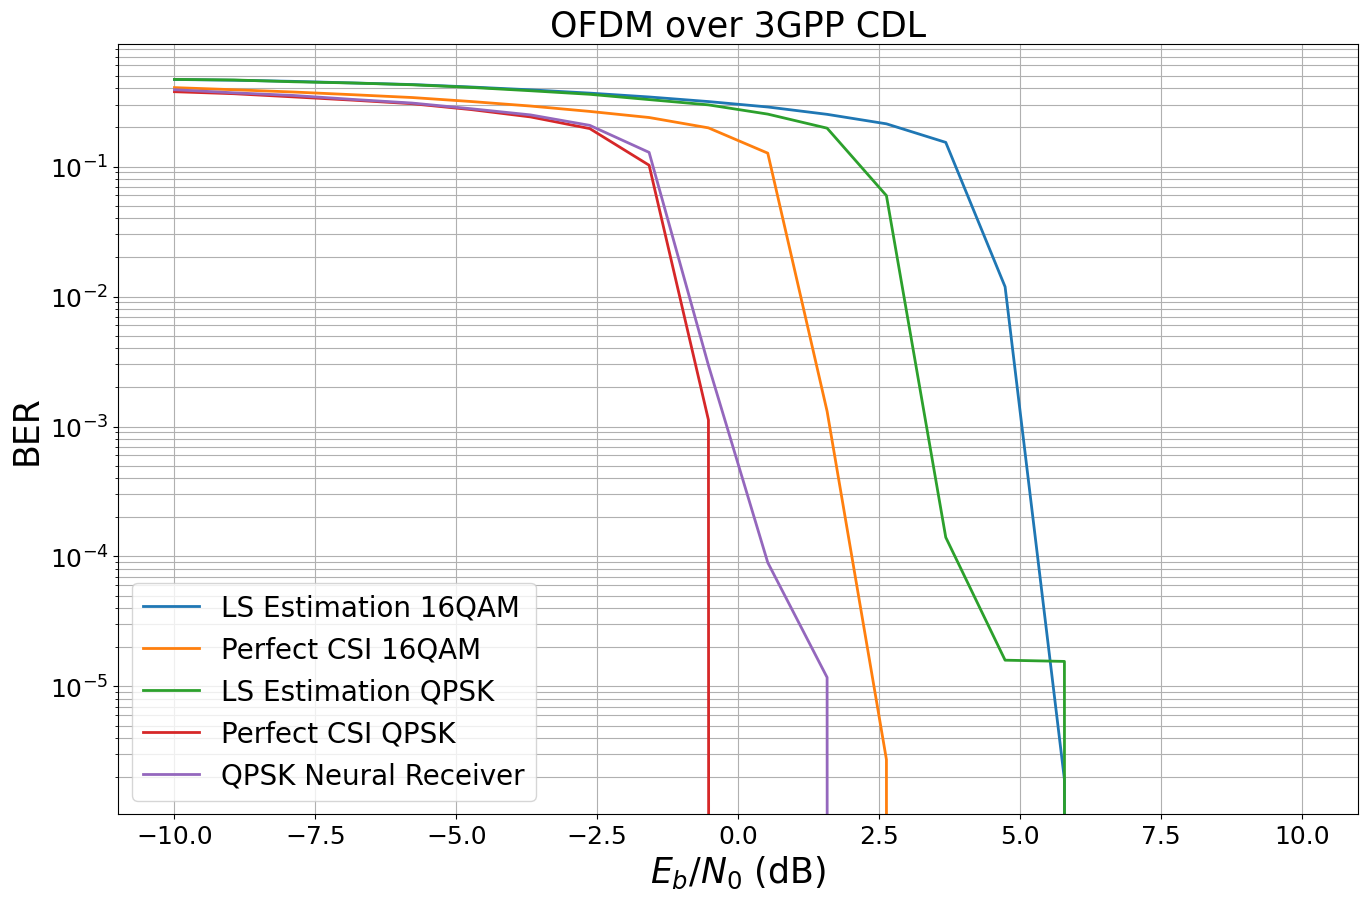

In [53]:
# Computing and plotting BER
ber_plots.simulate(model_neuralrx,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100,
                  legend="QPSK Neural Receiver",
                  soft_estimates=True,
                  max_mc_iter=100,
                  show_fig=True);

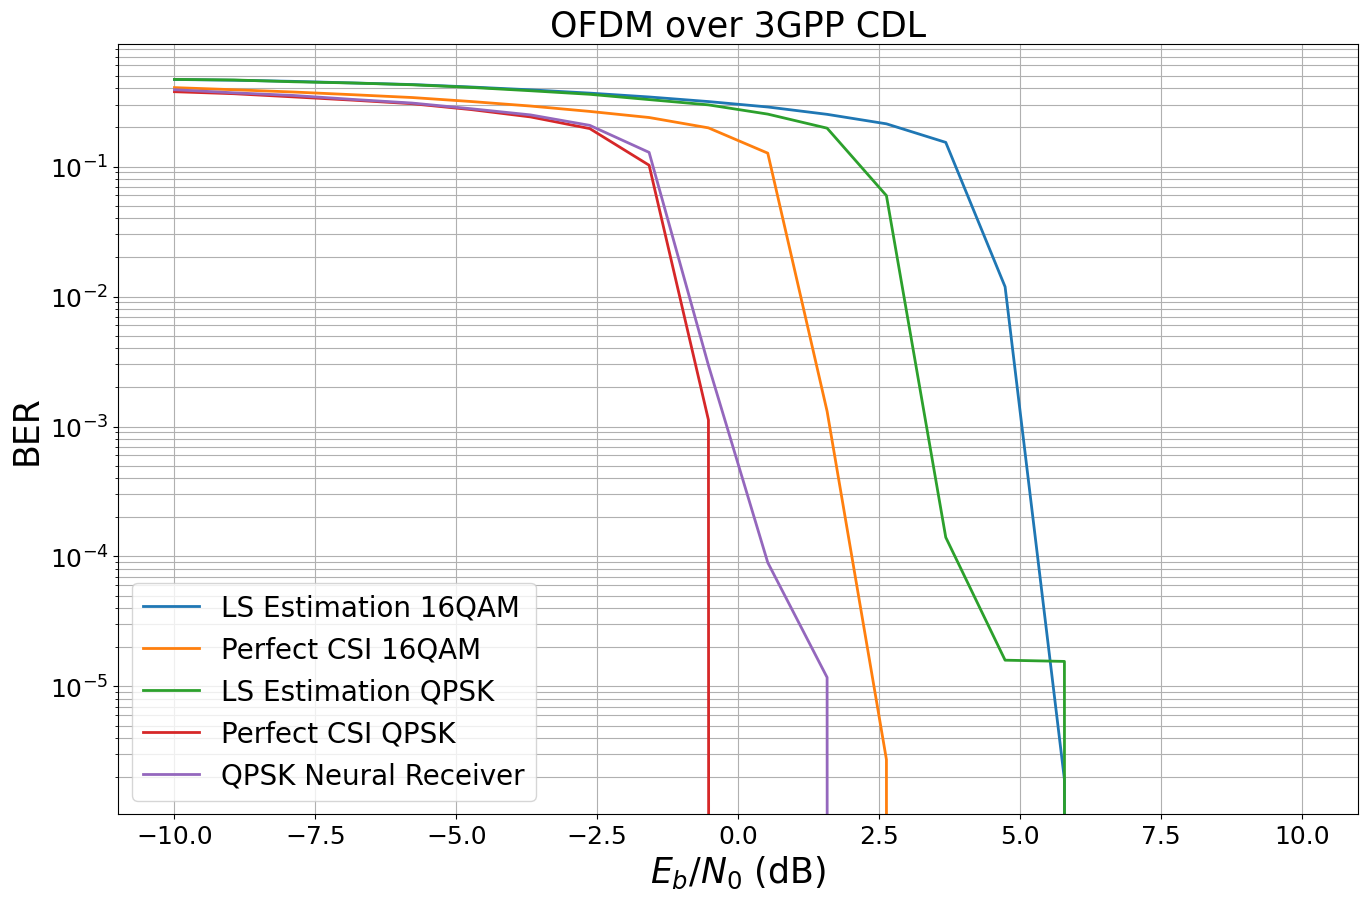

In [55]:
ber_plots();
plt.savefig(f"BER_OFDM", dpi=300, bbox_inches='tight')